# Natural Language Processing Project: Japanese ML Tweets

Coded by Luna McBride

The point of this notebook is to test Japanese language processing.

In [23]:
import sys #Used exclusively to get ja_core_news_lg, which does not save between sessions
!{sys.executable} -m spacy download ja_core_news_lg #Downloads ja_core_news_lg, which is used for spacy Japanese processing

✔ Download and installation successful
You can now load the model via spacy.load('ja_core_news_lg')


In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # regular expressions
import html # HTML content, like &amp;

import spacy #For general NLP
from spacy.lang.ja.stop_words import STOP_WORDS #Get the Japanese stopwords

import ja_core_news_lg #Japanese language handling
nlp =  ja_core_news_lg.load() #Initializing Spacy for Japanese
import operator #For dictionary sorting

import matplotlib.pylab as plt #For plot testing
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-tweet/Twitter ML Data.csv


---

# Load the dataset

In [4]:
tweetData = pd.read_csv("../input/ml-tweet/Twitter ML Data.csv") #Load the dataset into pandas
tweetData.head() #Take a peek at the dataset

,Name,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,aketaco,RT @odashi_t: 「機械学習がずるをしている（人間が想定しない推論を行う）から良く...,https://twitter.com/187400312/status/127142474...,Fri Jun 12 12:50:56 +0000 2020,NaN,NaN
4,Atsunov,RT @ML_deep: y = f(x)\n\nというモデルで、ひと目では分からぬような関...,https://twitter.com/14404737/status/1271428080...,Fri Jun 12 13:04:10 +0000 2020,NaN,NaN


---

# Add column names

In [5]:
tweetData = tweetData.rename(columns = {"Name" : "Tweeter", "2" : "OriginalTweet", "3" : "TweetLink", "4" : "TweetTime"}) #Changes the column names to something more helpful
tweetData.head() #Take a peek at the dataset

,Tweeter,OriginalTweet,TweetLink,TweetTime,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,aketaco,RT @odashi_t: 「機械学習がずるをしている（人間が想定しない推論を行う）から良く...,https://twitter.com/187400312/status/127142474...,Fri Jun 12 12:50:56 +0000 2020,NaN,NaN
4,Atsunov,RT @ML_deep: y = f(x)\n\nというモデルで、ひと目では分からぬような関...,https://twitter.com/14404737/status/1271428080...,Fri Jun 12 13:04:10 +0000 2020,NaN,NaN


---

# Check for and remove null values

In [6]:
print(tweetData.count()) #Get the counts of values in the dataset

#Check each column if there are any null values
print(tweetData["Tweeter"].isnull().any())
print(tweetData["OriginalTweet"].isnull().any())
print(tweetData["TweetLink"].isnull().any())
print(tweetData["TweetTime"].isnull().any())
print(tweetData["5"].isnull().any())
print(tweetData["6"].isnull().any())

Tweeter          1390
OriginalTweet    1390
TweetLink        1390
TweetTime        1390
5                   0
6                   0
dtype: int64
True
True
True
True
True
True


It appears there are no values at all in 5 and 6, so those should be removed entirely. There are also null rows, as shown in the head functions above, so I will just drop those with null tweets and see where to go from there

In [7]:
tweetData = tweetData.drop(columns = ["5", "6"]) #Drop the null columns
tweetData.head() #Take a peek at the dataset

,Tweeter,OriginalTweet,TweetLink,TweetTime
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,aketaco,RT @odashi_t: 「機械学習がずるをしている（人間が想定しない推論を行う）から良く...,https://twitter.com/187400312/status/127142474...,Fri Jun 12 12:50:56 +0000 2020
4,Atsunov,RT @ML_deep: y = f(x)\n\nというモデルで、ひと目では分からぬような関...,https://twitter.com/14404737/status/1271428080...,Fri Jun 12 13:04:10 +0000 2020


In [8]:
tweetData["OriginalTweet"] = tweetData["OriginalTweet"].apply(lambda x: np.nan if not x else x) #Change blank tweets to null as well
tweetData.dropna(subset = ["OriginalTweet"], inplace = True) #Drop the nulls based on the tweet data
tweetData.reset_index(drop=True, inplace=True) #Reset the index for later looping
tweetData.head() #Take a peek at the dataset

,Tweeter,OriginalTweet,TweetLink,TweetTime
0,aketaco,RT @odashi_t: 「機械学習がずるをしている（人間が想定しない推論を行う）から良く...,https://twitter.com/187400312/status/127142474...,Fri Jun 12 12:50:56 +0000 2020
1,Atsunov,RT @ML_deep: y = f(x)\n\nというモデルで、ひと目では分からぬような関...,https://twitter.com/14404737/status/1271428080...,Fri Jun 12 13:04:10 +0000 2020
2,arlequin_udon,この話をしていたら\n「その日記データを機械学習に食わせたら、勝手に日記書きだすんじゃね？」...,https://twitter.com/177861086/status/127142784...,Fri Jun 12 13:03:14 +0000 2020
3,daruchan524,RT @hokuto_sd: JSAI2020の社会データと予測のセッションで、共同研究をし...,https://twitter.com/1879931462/status/12714277...,Fri Jun 12 13:02:41 +0000 2020
4,usdatascientist,RT @unistud_ml: @usdatascientist 購入しました!昨日から見て...,https://twitter.com/1186121103992737792/status...,Fri Jun 12 13:02:24 +0000 2020


In [9]:
#Check each column if there are any null values
print(tweetData["Tweeter"].isnull().any())
print(tweetData["OriginalTweet"].isnull().any())
print(tweetData["TweetLink"].isnull().any())
print(tweetData["TweetTime"].isnull().any())

False
False
False
False


That took out all the null values. 

---

# Tweet cleaning

In [10]:
#Modified from my previous nlp project: https://www.kaggle.com/lunamcbride24/coronavirus-tweet-processing

punctuations = """!()（）「」、-!！[]{};:+'"\,<>./?@#$%^&*_~Â。…・，【】？""" #List of punctuations to remove, including a weird A that will not process out any other way

stopwords = spacy.lang.ja.stop_words.STOP_WORDS

#CleanTweets: parces the tweets and removes punctuation, stop words, digits, and links.
#Input: the list of tweets that need parsing
#Output: the parsed tweets
def cleanTweets(tweetParse):
    for i in range(0,len(tweetParse)):
        tweet = tweetParse[i] #Putting the tweet into a variable so that it is not calling tweetParse[i] over and over
        tweet = html.unescape(tweet) #Removes leftover HTML elements, such as &amp;
        tweet = re.sub(r"RT", ' ', tweet)
        tweet = re.sub(r"\n", ' ', tweet)
        tweet = re.sub(r"@\w+", ' ', tweet) #Completely removes @'s, as other peoples' usernames mean nothing
        tweet = re.sub(r'https\S+', ' ', tweet) #Removes links, as links provide no data in tweet analysis in themselves
        tweet = re.sub(r"\d+", ' ', tweet) #Removes numbers, as well as cases like the "th" in "14th"
        tweet = ''.join([punc for punc in tweet if not punc in punctuations]) #Removes the punctuation defined above
        tweet = tweet.lower() #Turning the tweets lowercase real quick for later use
    
        tweetWord = nlp.tokenizer(tweet) #Splits the tweet into individual words
        tweetParse[i] = ''.join([word.orth_ + " " for word in tweetWord if word.is_stop == False]) #Checks if the words are stop words
       
        
    return tweetParse #Returns the parsed tweets

tweets = tweetData["OriginalTweet"].copy() #Gets a copy of the tweets to send to the function call
tweetData["CleanTweet"] = cleanTweets(tweets) #Adds a CleanTweet column and fills it with processed tweets
print(tweetData["OriginalTweet"][3], "\n \n", tweetData["CleanTweet"][3]) #Prints an example sentence
tweetData.head() #Takes a peek at the dataframe

RT @hokuto_sd: JSAI2020の社会データと予測のセッションで、共同研究をしている桑田和さんが「機械学習アプローチに基づく中古ファッションアイテムの価格保持期間の適正化モデルの提案」というタイトルで発表しました！
#JSAI2020 
https://t.co/… 
 
      jsai 社会 データ 予測 セッション 共同 研究 桑田 和 機械 学習 アプローチ 基づく 中古 ファッション アイテム 価格 保持 期間 適正 化 モデル 提案 タイトル 発表 まし jsai     


,Tweeter,OriginalTweet,TweetLink,TweetTime,CleanTweet
0,aketaco,RT @odashi_t: 「機械学習がずるをしている（人間が想定しない推論を行う）から良く...,https://twitter.com/187400312/status/127142474...,Fri Jun 12 12:50:56 +0000 2020,機械 学習 ずる 人間 想定 推論 行う 良く 思う 人 人間 理解 推論 行う ...
1,Atsunov,RT @ML_deep: y = f(x)\n\nというモデルで、ひと目では分からぬような関...,https://twitter.com/14404737/status/1271428080...,Fri Jun 12 13:04:10 +0000 2020,y = fx モデル ひと目 分から 関係 性 大量 y x 求めよう 機械 ...
2,arlequin_udon,この話をしていたら\n「その日記データを機械学習に食わせたら、勝手に日記書きだすんじゃね？」...,https://twitter.com/177861086/status/127142784...,Fri Jun 12 13:03:14 +0000 2020,話 日記 データ 機械 学習 食わ 勝手に 日記 書き だす じゃ って 言わ 笑っ なに ...
3,daruchan524,RT @hokuto_sd: JSAI2020の社会データと予測のセッションで、共同研究をし...,https://twitter.com/1879931462/status/12714277...,Fri Jun 12 13:02:41 +0000 2020,jsai 社会 データ 予測 セッション 共同 研究 桑田 和 機械 学習 アプロ...
4,usdatascientist,RT @unistud_ml: @usdatascientist 購入しました!昨日から見て...,https://twitter.com/1186121103992737792/status...,Fri Jun 12 13:02:24 +0000 2020,購入 まし 昨日 見 すごく わかり やすい 機械 学習 使える 頑張っ 勉強


---

# Japanese Stopwords

In [11]:
print(list(stopwords)) #Print the stopwords for reference

['いずれ', 'に', 'ば', 'ほど', 'それぞれ', 'すぐ', 'ため', 'でき', 'なし', 'れ', 'いく', 'ほとんど', 'そこ', 'れる', 'なく', 'ない', 'ご', 'す', 'なお', 'ある', 'よう', 'ら', 'かつ', 'たら', 'なっ', 'しかし', 'いう', 'いる', 'そう', 'た', 'の', 'そして', 'できる', 'その', 'せる', 'しまっ', 'あれ', 'かなり', 'まま', 'き', 'み', 'も', 'から', 'かけ', 'なり', 'ここ', '一', 'どう', 'おり', 'か', 'へ', 'ます', 'にて', 'いっ', 'ながら', 'また', 'つつ', 'それ', 'が', 'ね', 'よる', 'たり', 'る', 'しまう', 'あまり', 'この', 'たち', 'い', 'なかっ', 'のみ', 'これ', 'つい', 'など', 'する', 'いわ', 'しよう', 'おけ', 'とも', 'よ', 'ごと', 'および', 'あり', 'より', 'あ', 'や', 'お', 'たい', 'ところ', 'は', 'られる', 'はじめ', 'もっ', 'しか', 'ひと', 'だっ', 'とっ', 'せい', 'のち', 'くる', 'らしい', 'で', 'し', 'まで', 'こう', 'すべて', 'あるいは', 'さ', 'ず', 'です', 'な', 'もう', 'なる', 'うち', 'よれ', 'ほぼ', 'もと', 'やっ', 'おい', 'ぶり', 'なら', 'こ', 'いい', 'ぬ', 'いつ', 'ただし', 'だ', 'べき', 'ん', 'おら', 'だけ', 'ほか', 'ちゃん', 'つけ', 'なけれ', 'え', 'て', 'られ', 'かつて', 'ま', 'と', 'とき', 'よっ', 'もの', 'くん', 'よく', 'つ', 'きっかけ', 'せ', 'こと', 'を', 'あっ', 'さん', 'ち', 'さらに']


---

# Get word counts

Quick source list: https://www.geeksforgeeks.org/python-get-first-n-keyvalue-pairs-in-given-dictionary/ , https://www.w3resource.com/python-exercises/dictionary/python-data-type-dictionary-exercise-1.php 

In [12]:
tweets = tweetData["CleanTweet"].copy() #Copy the clean tweets for processing
count = dict() #Creates a dictionary 
for i in range(0,len(tweets)):
    words = tweets[i].split()
    for word in words:
        if word in count:
            count[word] += 1
        else:
            count[word] = 1

sortCount = {word : summ for word, summ in sorted(count.items(), key=operator.itemgetter(1),reverse=True)}
print(dict(list(sortCount.items())[0: 20]))

{'学習': 1783, '機械': 1589, 'ai': 243, 'データ': 235, '的': 223, 'けど': 210, 'python': 193, '中国': 188, 'てる': 178, '性': 163, '人': 161, '世界': 156, '人工': 148, '知能': 147, 'って': 145, '第': 140, '可能': 139, '年': 133, 'プログラミング': 129, '次': 126}


Interestingly, there are several top options here that I would consider stopwords, but are not in the stopwords list. For example, けど, which means but, but is also used in sentences to imply another sentence (which is not something a machine can likely pick up on). The other words I would consider stopwords in the top 20 would be 的, てる, って, 第, and 次.

---

# Matplotlib Japanese Test

<BarContainer object of 20 artists>

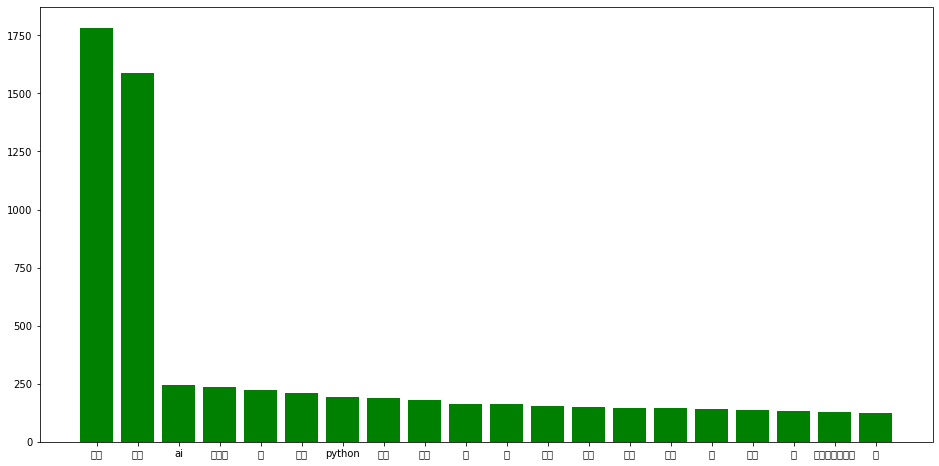

In [22]:
top = dict(list(sortCount.items())[0: 20])
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(16,8))
plt.bar(top.keys(), top.values(), color = "g")

As I sort of expected, Matplotlib does not recognize Japanese characters. It is the whole reason I wanted to test this.

---

# Conclusion

The spacy Japanese is pretty strong. Of course, I tried NLTK Japanese and could not get it to work at all, so at the very least, getting spacy up and working is pretty big. In terms of processing, Japanese is considered a big, single block by functions like split(). This thus requires tokenizing followed by getting the individual word out in order to actually process the text. And even when tokenized, words like 機械学習 (Machine Learning) that are made of two words are split into the two words, which is something to look out for. English may have concepts like this that are two words like machine learning, but Japanese words like this this often hold more meaning together than as the sum of their parts. 

This is followed by a check with the stopwords, which does not include some words that I would consider stopwords, so that is another thing to look out for when processing Japanese. One more key part of this is matplotlib, as it does not recognize Japanese characters at all. It just leaves boxes in the place of a character. This means numeric data like model accuracy hold a lot more value when working with Japanese than categorical data that would typically be powerful during exploration. 

As for the dataset itself, it is pretty barebones. It is machine learning, so the most common words (besides those I would consider stopwords), are expectedly machine, learning, AI, programming, and python. There are also words like ability (可能) and world (世界), so likely some optimistic discussion on changing the world and learning ability, similar to how it is discussed in English. 